In [2]:
pip install utils

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import utils

In [4]:

# # URL of the white wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

# # load the dataset from the URL
white_df = pd.read_csv(URL, sep=";")

# # fill the `is_red` column with zeros.
white_df["is_red"] = 0 # YOUR CODE HERE

# # keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')



In [5]:
white_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0


In [7]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])


8.8
9.1


In [8]:
# # URL of the red wine dataset
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

# # load the dataset from the URL
red_df = pd.read_csv(URL, sep=";")

# # fill the `is_red` column with ones.
red_df["is_red"] = 1 # YOUR CODE HERE

# # keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')



In [9]:
red_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1


In [10]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])


9.4
10.2


In [11]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [12]:
print(df.alcohol[0])
print(df.alcohol[100])



9.4
9.5


In [13]:
df = df.iloc[np.random.permutation(len(df))]
# np.random.permutation() : Randomly permute a sequence, or return a permuted(changed) range.

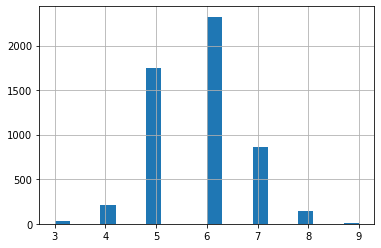

In [14]:
df['quality'].hist(bins=20);

In [15]:
# # get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# # reset index and drop the old one
df = df.reset_index(drop=True)

In [16]:
print(df.alcohol[0])
print(df.alcohol[100])



12.0
10.3


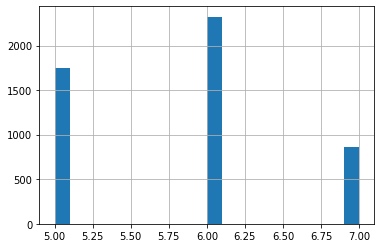

In [17]:
df['quality'].hist(bins=20);

In [18]:
# # split df into 80:20 train and test sets
train, test = train_test_split(df, test_size= 0.2, random_state = 1)
                               
# # split train into 80:20 train and val sets
train, val = train_test_split(train, test_size= 0.2, random_state = 1)

In [19]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [20]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.227322,1.331984,4.20000,6.4000,7.0000,7.7000,15.90000
volatile acidity,3155.0,0.341204,0.162770,0.08000,0.2300,0.3000,0.4100,1.33000
citric acid,3155.0,0.322254,0.148680,0.00000,0.2500,0.3100,0.4000,1.66000
residual sugar,3155.0,5.019303,4.384995,0.70000,1.8000,2.7000,7.5000,23.50000
chlorides,3155.0,0.057263,0.037707,0.00900,0.0380,0.0470,0.0680,0.61100
free sulfur dioxide,3155.0,30.076070,17.114415,1.00000,17.0000,28.0000,41.0000,128.00000
total sulfur dioxide,3155.0,114.025357,56.917146,6.00000,74.0000,116.0000,154.0000,344.00000
density,3155.0,0.994534,0.002899,0.98711,0.9922,0.9947,0.9968,1.00369
pH,3155.0,3.222288,0.155745,2.72000,3.1200,3.2100,3.3200,4.01000
sulphates,3155.0,0.535030,0.147690,0.22000,0.4400,0.5100,0.6000,1.98000


In [21]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [22]:
# # format the output of the train set
train_Y = format_output(train)

# # format the output of the val set
val_Y = format_output(val)
    
# # format the output of the test set
test_Y = format_output(test)

In [24]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,8.3,0.20,0.35,0.9,0.050,12.0,74.0,0.99200,3.13,0.38,10.5
3557,7.0,0.32,0.31,6.4,0.031,38.0,115.0,0.99235,3.38,0.58,12.2
3825,6.7,0.48,0.08,2.1,0.064,18.0,34.0,0.99552,3.33,0.64,9.7
1740,10.5,0.24,0.47,2.1,0.066,6.0,24.0,0.99780,3.15,0.90,11.0
1221,7.2,0.22,0.49,1.0,0.045,34.0,140.0,0.99000,3.05,0.34,12.7


In [25]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [26]:
# # normalize the train set
norm_train_X = norm(train)
    
# # normalize the val set
norm_val_X = norm(val)
    
# # normalize the test set
norm_test_X = norm(test)

In [27]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation= tf.nn.relu)(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = tf.keras.layers.Dense(128, activation= tf.nn.relu)(x)
    return x

In [28]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

    return model

In [29]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mean_squared_error'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )




In [30]:
history = model.fit(norm_train_X,train_Y,
                    epochs = 180, validation_data=(norm_val_X, val_Y))

Epoch 1/180
99/99 [==============================] - 2s 5ms/step - loss: 27.3672 - wine_quality_loss: 26.7297 - wine_type_loss: 0.6375 - wine_quality_root_mean_squared_error: 5.1630 - wine_type_accuracy: 0.6468 - val_loss: 15.0191 - val_wine_quality_loss: 14.4599 - val_wine_type_loss: 0.5591 - val_wine_quality_root_mean_squared_error: 3.8026 - val_wine_type_accuracy: 0.7820
Epoch 2/180
99/99 [==============================] - 0s 2ms/step - loss: 11.6777 - wine_quality_loss: 11.1299 - wine_type_loss: 0.5479 - wine_quality_root_mean_squared_error: 3.3248 - wine_type_accuracy: 0.7616 - val_loss: 4.9472 - val_wine_quality_loss: 4.4664 - val_wine_type_loss: 0.4808 - val_wine_quality_root_mean_squared_error: 2.1134 - val_wine_type_accuracy: 0.7490
Epoch 3/180
99/99 [==============================] - 0s 2ms/step - loss: 3.6224 - wine_quality_loss: 3.1603 - wine_type_loss: 0.4621 - wine_quality_root_mean_squared_error: 1.7754 - wine_type_accuracy: 0.7524 - val_loss: 2.9668 - val_wine_quality_l

In [31]:
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')



25/25 [==============================] - 0s 1ms/step - loss: 0.4076 - wine_quality_loss: 0.3751 - wine_type_loss: 0.0325 - wine_quality_root_mean_squared_error: 0.6124 - wine_type_accuracy: 0.9911

loss: 0.40760502219200134
wine_quality_loss: 0.3750899136066437
wine_type_loss: 0.032515041530132294
wine_quality_rmse: 0.6124458312988281
wine_type_accuracy: 0.9911280274391174


In [32]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [33]:
print(quality_pred[0])



[6.130107]


In [34]:
print(type_pred[0])
print(type_pred[944])


[0.9999989]
[0.9995911]


In [35]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)



In [36]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [37]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

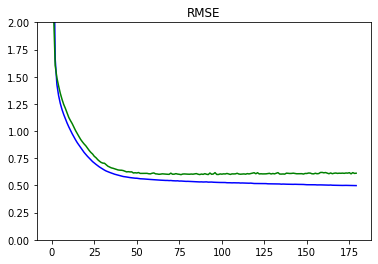

In [38]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

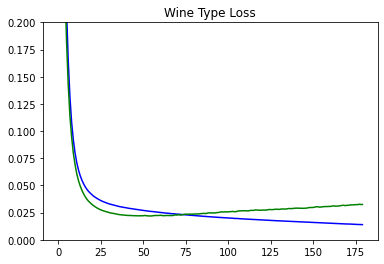

In [39]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

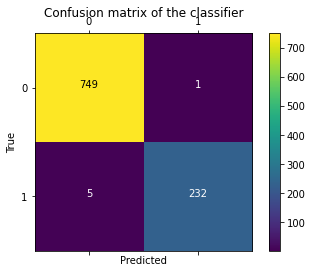

In [40]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

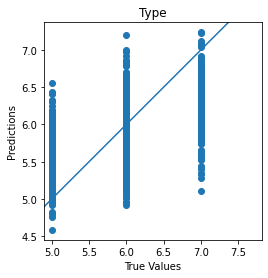

In [41]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')